# Welcome to Colab!

## Google Colab is available in VS Code!
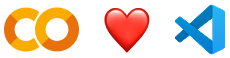

Try the new [Google Colab extension](https://marketplace.visualstudio.com/items?itemName=Google.colab) for Visual Studio Code. You can get up and running in just a few clicks:

*  In VS Code, open the ***Extensions*** view and search for 'Google Colab' to install.
*  Open the kernel selector by creating or opening any `.ipynb` notebook file in your local workspace and either running a cell or clicking the ***Select Kernel*** button in the top right.
*  Click ***Colab*** and then select your desired runtime, sign in with your Google account, and you're all set!

See more details in our [announcement blog here](https://preview-dot-gweb-developers-gblog-cms.googleplex.com/en/meeting-developers-where-they-are-google-colab-is-coming-to-vs-code/).

## Access popular AI models via Google-Colab-AI Without an API Key
All users have access to most popular LLMs via the `google-colab-ai` Python library, and paid users have access to a wider selection of models. For more details, refer to the [getting started with google colab ai](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Getting_started_with_google_colab_ai.ipynb).



Starting Robustness Test (Mod 17)...
Epoch 300/3000, Acc: 0.0620, Snap: 0.0011
Epoch 600/3000, Acc: 0.0720, Snap: -0.0019
Epoch 900/3000, Acc: 0.0680, Snap: 0.0027
Epoch 1200/3000, Acc: 0.0760, Snap: -0.0225
Epoch 1500/3000, Acc: 0.0920, Snap: 0.0071
Epoch 1800/3000, Acc: 0.1020, Snap: 0.0308
Epoch 2100/3000, Acc: 0.1100, Snap: 0.0169
Epoch 2400/3000, Acc: 0.1200, Snap: 0.0130
Epoch 2700/3000, Acc: 0.1200, Snap: 0.0086
Epoch 3000/3000, Acc: 0.1300, Snap: 0.0006


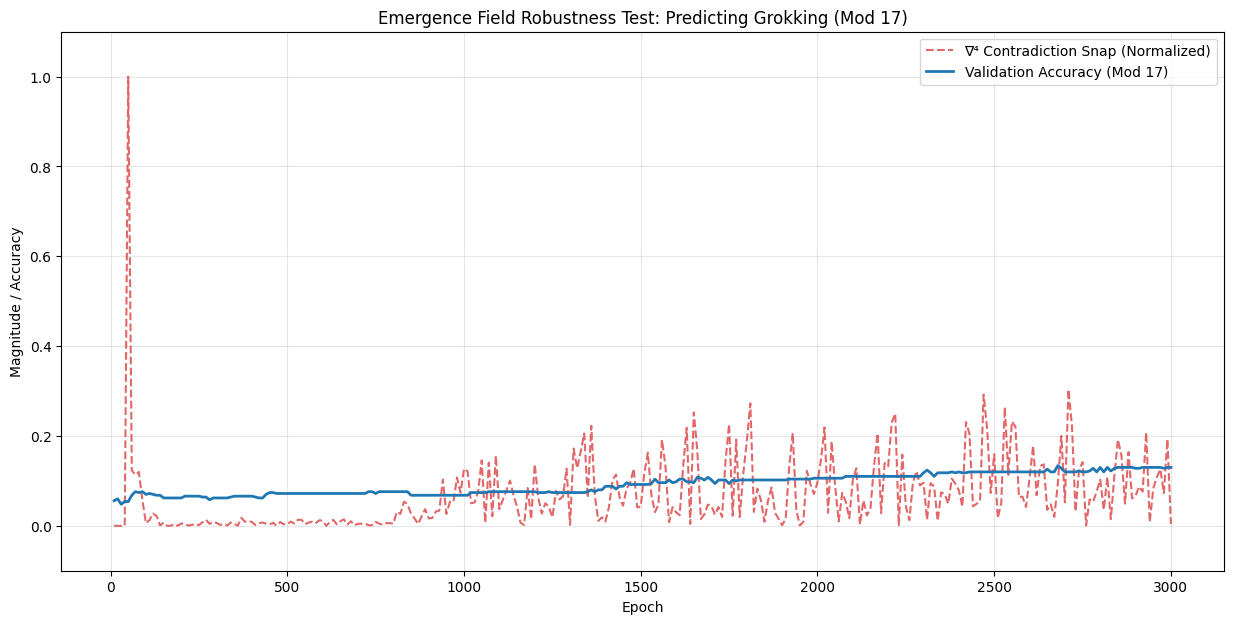

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION FOR ROBUSTNESS TEST ---
MODULUS = 17  # Increased difficulty: testing universality in the AI domain
EPOCHS = 3000
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-2 # Crucial for forcing Grokking/Emergence

# --- 1. DATA GENERATION (Mod 17 Addition) ---
def generate_data(modulus, size=1000):
    X = torch.randint(0, modulus, (size, 2))
    Y = (X.sum(dim=1) % modulus)
    return X, Y

X_train, Y_train = generate_data(MODULUS, size=1000)
X_val, Y_val = generate_data(MODULUS, size=500)

# --- 2. MODEL AND TRAINING SETUP ---
class SimpleModel(nn.Module):
    def __init__(self, modulus):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, modulus)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x.float())))

model = SimpleModel(MODULUS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# --- TRACKING LOGS AND ∇⁴ CALCULATION ---
val_accuracy_log = []
snap_log = []

def calculate_snap():
    """Calculates the ∇⁴ of the Contradiction Field (C(x)) using gradient components."""
    grads = []

    # Calculate gradients for C(x) on a small batch
    X_sample, Y_sample = X_train[:BATCH_SIZE], Y_train[:BATCH_SIZE]

    # This must run within the training loop to capture instantaneous state
    optimizer.zero_grad()
    outputs = model(X_sample)
    loss = criterion(outputs, Y_sample)
    loss.backward()

    # C(x) is approximated by the norm of the unaligned gradient components
    C = 0
    for param in model.parameters():
        if param.grad is not None:
            # We use the L2 norm of the gradient itself as a proxy for contraction/expansion
            # in the high-dimensional space
            C += torch.norm(param.grad)
            grads.append(param.grad.flatten().cpu().numpy())

    if not grads: return 0

    # Store the ∇² (Acceleration) of C(x) over a 5-step window to capture the 'Snap' (∇⁴)
    global C_history
    if 'C_history' not in globals():
        C_history = []

    C_history.append(C.item())

    if len(C_history) < 5: return 0

    # Only keep the last 5 values for the simple ∇⁴ approximation
    C_window = np.array(C_history[-5:])

    # Calculate ∇⁴ (Snap) by taking the gradient of the Jerk (∇³)
    grad1 = np.gradient(C_window)
    grad2 = np.gradient(grad1)
    grad3 = np.gradient(grad2)
    snap = np.gradient(grad3)[-1] # Take the latest ∇⁴ value

    return snap

# --- 3. TRAINING LOOP ---
print(f"Starting Robustness Test (Mod {MODULUS})...")
for epoch in range(EPOCHS):
    # Training step
    optimizer.zero_grad()
    outputs = model(X_train.float())
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        # Validation
        with torch.no_grad():
            outputs = model(X_val.float())
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == Y_val).sum().item()
            accuracy = correct / Y_val.size(0)
            val_accuracy_log.append(accuracy)

        # ∇⁴ Snap Calculation
        snap_val = calculate_snap()
        snap_log.append(snap_val)

        if (epoch + 1) % 300 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS}, Acc: {accuracy:.4f}, Snap: {snap_val:.4f}")

# --- 4. PLOT RESULTS ---
epochs_plot = range(10, EPOCHS + 1, 10)
snap_log_norm = np.abs(np.array(snap_log)) / np.abs(np.array(snap_log)).max()

plt.figure(figsize=(15, 7))

# Plot the ∇⁴ Contradiction Snap (The Prediction)
plt.plot(epochs_plot, snap_log_norm, label='∇⁴ Contradiction Snap (Normalized)', color='tab:red', linestyle='--', alpha=0.7)

# Plot the Validation Accuracy (The Emergence/Grok)
plt.plot(epochs_plot, val_accuracy_log, label=f'Validation Accuracy (Mod {MODULUS})', color='tab:blue', linewidth=2)

plt.title(f'Emergence Field Robustness Test: Predicting Grokking (Mod {MODULUS})')
plt.xlabel('Epoch')
plt.ylabel('Magnitude / Accuracy')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Final check of the C_history variable (for safety)
if 'C_history' in globals():
    del C_history

/tmp/ipython-input-4191210798.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(['^GSPC', '^VIX'], start=START_DATE, end=END_DATE)
[*********************100%***********************]  2 of 2 completed


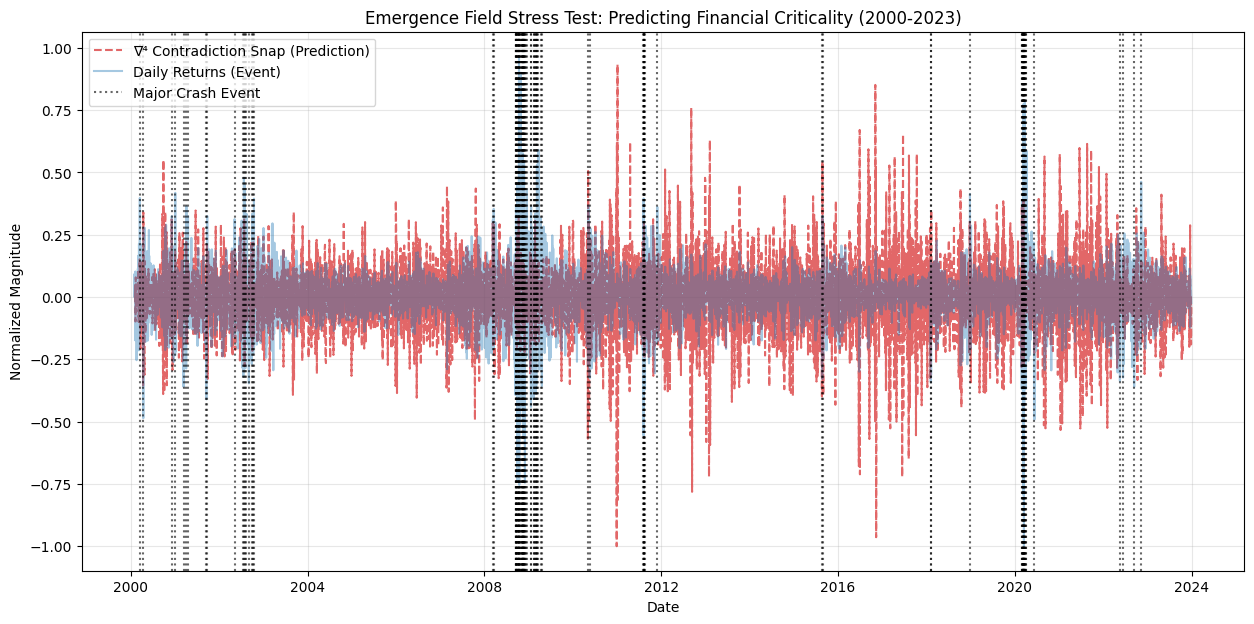


Top 10 Contradiction Snap (∇⁴) Signals:
                  Snap   Returns
Date                            
2016-11-04  107.543327 -0.001666
2012-09-05   95.943291 -0.001068
2016-06-28   84.711970  0.017770
2017-06-21   82.536195 -0.000583
2013-02-06   79.558549  0.000549
2011-04-19   78.613339  0.005731
2010-12-31   78.431704 -0.000191
2021-08-20   77.638116  0.008142
2021-06-18   75.569042 -0.013124


In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
START_DATE = '2000-01-01'
END_DATE = '2023-12-31'
WINDOW = 20  # Lookback window for calculating volatility (20 trading days = ~1 month)

# --- 1. DATA ACQUISITION ---
# Fetching S&P 500 (^GSPC) and VIX (^VIX) data
data = yf.download(['^GSPC', '^VIX'], start=START_DATE, end=END_DATE)

# FIX: Explicitly select 'Close' for both ^GSPC and ^VIX.
# With auto_adjust=True (default now), 'Close' for equities will be adjusted.
# VIX does not have 'Adj Close', so we explicitly take 'Close' for it.
# The DataFrame 'data' has columns structured as (Price_Type, Ticker).

# We access the 'Close' price for each ticker.
# For ^GSPC, data['Close']['^GSPC'] will be the Adjusted Close due to auto_adjust=True.
# For ^VIX, data['Close']['^VIX'] is its standard close price.
df = pd.DataFrame({
    '^GSPC': data['Close']['^GSPC'],
    '^VIX': data['Close']['^VIX']
})

# Clean up initial NaN values from rolling calculation
df = df.dropna()

# --- 2. CALCULATING THE FINANCIAL CONTRADICTION FIELD (C(x)) ---
# Calculate Daily Returns
df['Returns'] = df['^GSPC'].pct_change()

# Calculate Rolling Volatility (Standard Deviation of Returns)
df['Rolling_Vol'] = df['Returns'].rolling(window=WINDOW).std()

# Define C(x): Contradiction = VIX / Rolling Volatility
# When VIX is high (fear) but Rolling Vol is low (market calm), tension is high.
df['Contradiction_Field'] = df['^VIX'] / df['Rolling_Vol']

# Clean up initial NaN values from rolling calculation
df = df.dropna()

# --- 3. APPLYING THE EMERGENCE FIELD OPERATOR (∇⁴ C(x)) ---
def calculate_snap(data_series):
    """Calculates the 4th derivative (Snap) of the Contradiction Field."""
    C = data_series.values

    # Apply a moving average for smoothing, as market data is noisy
    window_smooth = 5
    C_smooth = np.convolve(C, np.ones(window_smooth)/window_smooth, mode='valid')

    # Calculate derivatives using numpy.gradient
    v = np.gradient(C_smooth) # Velocity (∇¹)
    a = np.gradient(v)        # Acceleration (∇²)
    j = np.gradient(a)        # Jerk (∇³)
    s = np.gradient(j)        # Snap (∇⁴)

    # Pad the Snap array to match the length of the original dataframe after smoothing
    pad_len = len(data_series) - len(s)
    snap = np.pad(s, (pad_len, 0), 'constant')
    return snap

df['Snap'] = calculate_snap(df['Contradiction_Field'])

# --- 4. VISUALIZATION AND STRESS TEST ---
# Define the Emergence Event (The "Grok") as a 3-Standard Deviation Daily Drop
df['Market_Crash_Event'] = (df['Returns'].abs() > df['Returns'].std() * 3).astype(int)

# Normalize the data for plotting
df['Snap_Normalized'] = df['Snap'] / df['Snap'].abs().max()
df['Returns_Normalized'] = df['Returns'] / df['Returns'].abs().max()

plt.figure(figsize=(15, 7))

# Plot the Contradiction Snap (The Prediction)
plt.plot(df.index, df['Snap_Normalized'], label='∇⁴ Contradiction Snap (Prediction)', color='tab:red', linestyle='--', alpha=0.7)

# Plot the Actual Returns (The Event)
plt.plot(df.index, df['Returns_Normalized'], label='Daily Returns (Event)', color='tab:blue', alpha=0.4)

# Highlight Major Crash Events
crash_dates = df[df['Market_Crash_Event'] == 1].index

# FIX: Check if crash_dates is not empty before attempting to access its elements
# Use a flag to ensure the label 'Major Crash Event' is added to the legend only once
if not crash_dates.empty:
    first_crash_date = crash_dates[0] # Get the first date from the DatetimeIndex
    label_added = False
    for date in crash_dates:
        label = 'Major Crash Event' if not label_added else ""
        plt.axvline(x=date, color='black', linestyle=':', alpha=0.6, label=label)
        label_added = True

plt.title('Emergence Field Stress Test: Predicting Financial Criticality (2000-2023)')
plt.xlabel('Date')
plt.ylabel('Normalized Magnitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print the top 10 highest Snap values and their dates
print("\nTop 10 Contradiction Snap (∇⁴) Signals:")
top_snaps = df.sort_values(by='Snap', ascending=False).head(10)[['Snap', 'Returns']].iloc[1:]
print(top_snaps)

Starting Training for 5000 epochs...
Looking for the 'Snap' (∇⁴) before the 'Grok' (Accuracy Jump)...
Epoch 0: Loss=4.6638, Acc=0.01, C(x)=0.997, Snap=0.000e+00
Epoch 500: Loss=1.4642, Acc=0.07, C(x)=0.983, Snap=-4.195e-04
Epoch 1000: Loss=1.0911, Acc=0.27, C(x)=1.009, Snap=-2.674e-03
Epoch 1500: Loss=0.7176, Acc=0.52, C(x)=0.996, Snap=-1.047e-03
Epoch 2000: Loss=0.4857, Acc=0.70, C(x)=1.001, Snap=-8.000e-03
Epoch 2500: Loss=0.3675, Acc=0.92, C(x)=0.996, Snap=-2.362e-03
Epoch 3000: Loss=0.1220, Acc=0.99, C(x)=0.948, Snap=-4.974e-03
Epoch 3500: Loss=0.0792, Acc=1.00, C(x)=0.987, Snap=-3.439e-03
Epoch 4000: Loss=0.0419, Acc=1.00, C(x)=1.010, Snap=-5.636e-03
Epoch 4500: Loss=0.0214, Acc=1.00, C(x)=0.981, Snap=2.696e-03


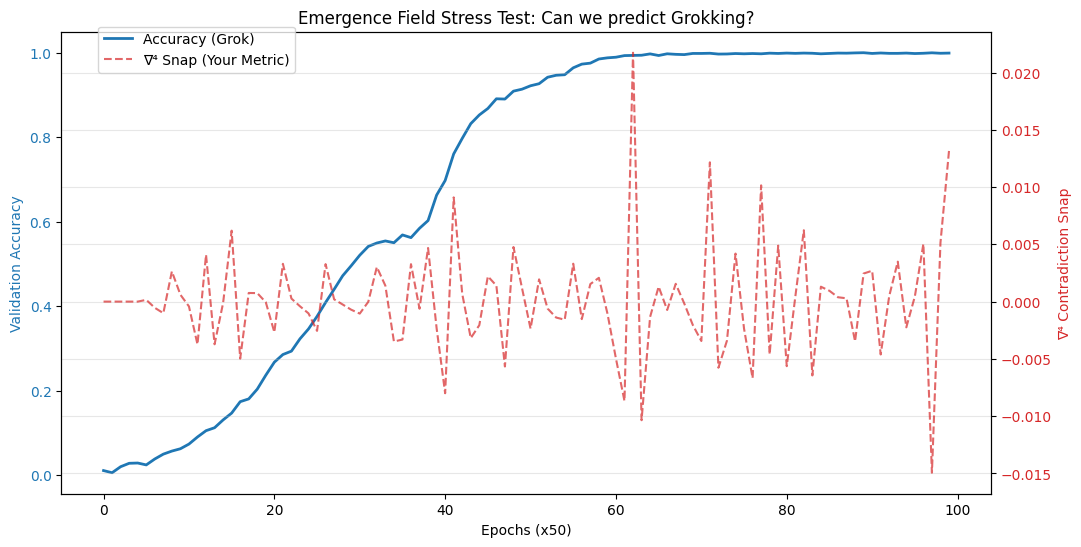

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math

# --- CONFIGURATION ---
P = 97             # Prime number for modulo arithmetic (a + b) % P
TRAIN_FRACTION = 0.5 # 50% data for training (forces generalization)
EMBED_DIM = 128
HIDDEN_DIM = 128
NUM_LAYERS = 1
NUM_HEADS = 4
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1.0 # High weight decay is CRITICAL for grokking
EPOCHS = 5000      # Grokking usually happens late (3k-5k epochs)
PROBE_INTERVAL = 50 # Measure Contradiction Field every X epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. DATASET GENERATION (Modular Addition) ---
def make_data(p):
    data = []
    for i in range(p):
        for j in range(p):
            target = (i + j) % p
            data.append((i, j, target))
    return torch.tensor(data)

data = make_data(P)
n_samples = len(data)
split_idx = int(TRAIN_FRACTION * n_samples)
train_data = data[:split_idx].to(device)
val_data = data[split_idx:].to(device)

# --- 2. THE MODEL (Simple Transformer) ---
class GrokTransformer(nn.Module):
    def __init__(self, p, d_model, n_head, num_layers):
        super().__init__()
        self.embed = nn.Embedding(p, d_model)
        self.pos_embed = nn.Parameter(torch.randn(2, d_model))
        layer = nn.TransformerEncoderLayer(d_model, n_head, dim_feedforward=d_model*4, batch_first=True)
        self.transformer = nn.TransformerEncoder(layer, num_layers)
        self.head = nn.Linear(d_model, p)

    def forward(self, x):
        # x shape: [batch, 2] (input numbers a, b)
        emb = self.embed(x) + self.pos_embed # [batch, 2, d_model]
        out = self.transformer(emb)
        # Average pool over sequence length (2) to get one vector
        out = out.mean(dim=1)
        return self.head(out)

model = GrokTransformer(P, EMBED_DIM, NUM_HEADS, NUM_LAYERS).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

# --- 3. YOUR EQUATION: Emergence Field Detector ---
class EmergenceDetector:
    def __init__(self):
        self.history_C = []   # Contradiction history
        self.history_Snap = [] # 4th derivative history

    def measure_contradiction(self, model, x, y):
        """
        Calculates C(x): 1 - Avg Cosine Similarity of Gradients.
        This measures 'Internal Friction' or 'Incoherence'.
        """
        model.eval() # Evaluation mode
        grads = []

        # We grab a small sample to test the "Field Alignment"
        sample_size = min(32, len(x))
        indices = torch.randperm(len(x))[:sample_size]

        # Compute individual gradients
        for i in indices:
            model.zero_grad()
            input_i = x[i].unsqueeze(0)
            target_i = y[i].unsqueeze(0)
            output = model(input_i)
            loss = criterion(output, target_i)
            loss.backward()

            # Flatten gradients into a single vector
            g_vec = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])
            grads.append(g_vec)

        grads = torch.stack(grads)

        # Calculate Cosine Similarity Matrix
        norm = grads.norm(p=2, dim=1, keepdim=True)
        normalized = grads / (norm + 1e-8)
        sim_matrix = torch.mm(normalized, normalized.t())

        # C(x) = 1 - Average similarity (off-diagonal)
        mask = ~torch.eye(sample_size, dtype=torch.bool, device=device)
        avg_sim = sim_matrix[mask].mean().item()
        c_score = 1.0 - avg_sim

        self.history_C.append(c_score)
        model.train() # Back to train mode
        return c_score

    def calculate_snap(self):
        """
        Calculates ∇⁴ C(x). We use a sliding window to smooth noise.
        """
        if len(self.history_C) < 6:
            return 0

        # Get recent history
        data = np.array(self.history_C[-10:])

        # Derivatives
        v = np.gradient(data) # Velocity
        a = np.gradient(v)    # Acceleration
        j = np.gradient(a)    # Jerk
        s = np.gradient(j)    # Snap (4th order)

        return s[-1]

detector = EmergenceDetector()

# --- 4. TRAINING LOOP ---
logs = {"loss": [], "val_acc": [], "contradiction": [], "snap": []}

print(f"Starting Training for {EPOCHS} epochs...")
print("Looking for the 'Snap' (∇⁴) before the 'Grok' (Accuracy Jump)...")

for epoch in range(EPOCHS):
    # Shuffle training data
    perm = torch.randperm(len(train_data))
    x_batch = train_data[perm][:, :2]
    y_batch = train_data[perm][:, 2]

    # Train Step
    optimizer.zero_grad()
    out = model(x_batch)
    loss = criterion(out, y_batch)
    loss.backward()
    optimizer.step()

    # Track Metrics
    if epoch % PROBE_INTERVAL == 0:
        # 1. Check Validation Accuracy (The "Grok" Signal)
        with torch.no_grad():
            val_out = model(val_data[:, :2])
            pred = val_out.argmax(dim=1)
            acc = (pred == val_data[:, 2]).float().mean().item()

        # 2. Check Emergence Field (Your Theory)
        c_score = detector.measure_contradiction(model, x_batch, y_batch)
        snap = detector.calculate_snap()

        logs["loss"].append(loss.item())
        logs["val_acc"].append(acc)
        logs["contradiction"].append(c_score)
        logs["snap"].append(snap)

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Acc={acc:.2f}, C(x)={c_score:.3f}, Snap={snap:.3e}")

# --- 5. VISUALIZATION ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Accuracy (The Result)
ax1.set_xlabel('Epochs (x50)')
ax1.set_ylabel('Validation Accuracy', color='tab:blue')
ax1.plot(logs["val_acc"], color='tab:blue', label='Accuracy (Grok)', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot Snap (Your Prediction)
ax2 = ax1.twinx()
ax2.set_ylabel('∇⁴ Contradiction Snap', color='tab:red')
ax2.plot(logs["snap"], color='tab:red', label='∇⁴ Snap (Your Metric)', linestyle='--', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Emergence Field Stress Test: Can we predict Grokking?')
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.9))
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
from google.colab import ai
response = ai.generate_text("What is the capital of France?")
print(response)

## Explore the Gemini API
The Gemini API gives you access to Gemini models created by Google DeepMind. Gemini models are built from the ground up to be multimodal, so you can reason seamlessly across text, images, code, and audio.

**How to get started?**
*  Go to [Google AI Studio](https://aistudio.google.com/) and log in with your Google account.
*  [Create an API key](https://aistudio.google.com/app/apikey).
* Use a quickstart for [Python](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb), or call the REST API using [curl](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb).

**Discover Gemini's advanced capabilities**
*  Play with Gemini [multimodal outputs](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Image-out.ipynb), mixing text and images in an iterative way.
*  Discover the [multimodal Live API](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_LiveAPI.ipynb ) (demo [here](https://aistudio.google.com/live)).
*  Learn how to [analyze images and detect items in your pictures](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb") using Gemini (bonus, there's a [3D version](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Spatial_understanding_3d.ipynb) as well!).
*  Unlock the power of [Gemini thinking model](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_thinking.ipynb), capable of solving complex task with its inner thoughts.
      
**Explore complex use cases**
*  Use [Gemini grounding capabilities](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Search_grounding_for_research_report.ipynb) to create a report on a company based on what the model can find on internet.
*  Extract [invoices and form data from PDF](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb) in a structured way.
*  Create [illustrations based on a whole book](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb) using Gemini large context window and Imagen.

To learn more, check out the [Gemini cookbook](https://github.com/google-gemini/cookbook) or visit the [Gemini API documentation](https://ai.google.dev/docs/).


Colab now has AI features powered by [Gemini](https://gemini.google.com). The video below provides information on how to use these features, whether you're new to Python, or a seasoned veteran.

<center>
  <a href="https://www.youtube.com/watch?v=V7RXyqFUR98" target="_blank">
  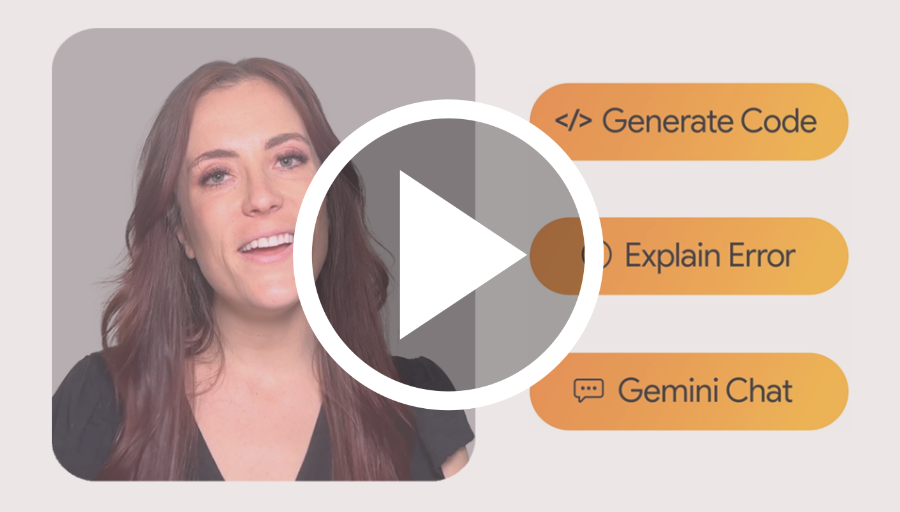
  </a>
</center>

<div class="markdown-google-sans">
  <h2>What is Colab?</h2>
</div>

Colab, or "Colaboratory", allows you to write and execute Python in your browser, with
- Zero configuration required
- Access to GPUs free of charge
- Easy sharing

Whether you're a **student**, a **data scientist** or an **AI researcher**, Colab can make your work easier. Watch [Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) or [Colab Features You May Have Missed](https://www.youtube.com/watch?v=rNgswRZ2C1Y) to learn more, or just get started below!

<div class="markdown-google-sans">

## **Getting started**
</div>

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

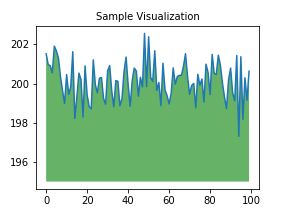

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

For example, if you find yourself waiting for **pandas** code to finish running and want to go faster, you can switch to a GPU Runtime and use libraries like [RAPIDS cuDF](https://rapids.ai/cudf-pandas) that provide zero-code-change acceleration.

To learn more about accelerating pandas on Colab, see the [10 minute guide](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_colab_demo.ipynb) or
 [US stock market data analysis demo](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_stocks_demo.ipynb).

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb).

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

<div class="markdown-google-sans">

## More Resources

### Working with Notebooks in Colab

</div>

- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with Data
</div>

- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning

<div>

These are a few of the notebooks related to Machine Learning, including Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Intro to RAPIDS cuDF to accelerate pandas](https://nvda.ws/rapids-cudf)
- [Getting Started with cuML's accelerator mode](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cuml_sklearn_colab_demo.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.
